## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

In [4]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

HTTPError: HTTP Error 404: Not Found

## Train forecaster

In [30]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(),
                    lags      = 15
                )

forecaster.fit(y=data_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

## Prediction

In [31]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

fecha
2005-07-01    0.973131
2005-08-01    1.022154
2005-09-01    1.151334
Freq: MS, dtype: float64

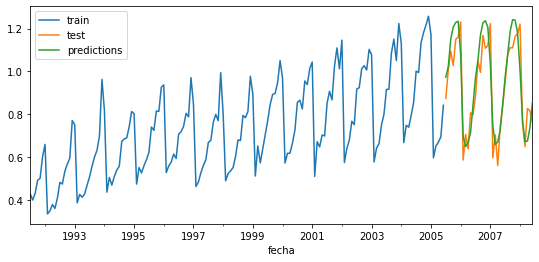

In [32]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [33]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.009918738501371805


## Feature importance

In [38]:
# When using as regressor LinearRegression, Ridge or Lasso
forecaster.get_coef()

# When using as regressor RandomForestRegressor or GradientBoostingRegressor
# forecaster.get_feature_importances()

array([ 1.58096176e-01,  6.18241513e-02,  6.44665806e-02, -2.41792429e-02,
       -2.60679572e-02,  7.04191008e-04, -4.28090339e-02,  4.87464352e-04,
        1.66853207e-02,  1.00022527e-02,  1.62219885e-01,  6.15595305e-01,
        2.85168042e-02, -7.31915864e-02, -5.38785052e-02])

## Extract training matrix

In [37]:
X, y = forecaster.create_train_X_y(data_train)